# Capstone Project - Capitals Clusters

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The capital cities of the world are very diverse, but also, share some common places. Sometimes it can be quite difficult to compare big cities using demographic or GPP data, because these numbers don't give you enough insights about the business environment.

This project is intended for managers of big multinational businesses who want to locate a new branch in another country that has a similiar set of venues. Is Washington more like Ottawa, Paris or Santiago de Chile?

To do that, you need to compare the capital cities and determine how similar or dissimilar they are, using data.

## Data  <a name="data"></a>

To determine the similarity of dissimilarity of the cities we are going to compare the venues present on each city and their categories, using the FourSquare API.

To get the capitals of the world we are going to use a table from Wikipedia. [List of national capitals](https://en.wikipedia.org/wiki/List_of_national_capitals_by_population)

For every city, we will get their location using the geocoder from the geopy library.

Using this locations, we are going to get their venues and categories from the API, and store them into a pandas DataFrame. To do that, we will use the explore query.

> `https://api.foursquare.com/v2/venues/`**explore**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&limit=`**LIMIT**

We need to make a table with the capital cities and the number of categories, like the example.

| Capital    | 1st Most Common Venue | 2nd Most Common Venue | 3rd Most Common Venue | 4th Most Common Venue |
|------------|--------|------------|-------|-----|
| Washington | Pizza      | Italian         | Mall     | Cinema   |
| Santiago   | Cinema     | Pizza          | Beach     | Hotel   |
| Paris      | Historic Place     | Mall          | Hotel    | Pool   |

Using this data we then are going to make clusters using k-means algorithm. Then we can visualize and analyze the resulting clusters using Folium and the capital's locations.

## Methodology  <a name="methodology"></a>

To make this project we are going to make the next steps:

* Read data from Wikipedia using pandas.
* Get the location (lat, long) for each city using geopy.
* Get the venues from FourSquare API.
* Create dataframe using categories and cities.
* Clean and structure data for clustering.
* Check results.

### First let's read the data from Wikipedia using pandas.

In [2]:
import pandas as pd
import numpy as np

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_national_capitals_by_population'

dataframe_list = pd.read_html(url, flavor='bs4')

capital_data = dataframe_list[1]
capital_data.head()

,Country (or territory),Capital,Population,% of country,Source
0,China (more),Beijing,21542000,1.5%,[1]2010
1,Japan (more),Tokyo,13929286,11.0%,[2]2017
2,DR Congo,Kinshasa,12691000,15.1%,[3]2017
3,Russia (more),Moscow,12506468,8.6%,[4]2011
4,Indonesia (more),Jakarta,10075310,3.8%,[5]2011


In [4]:
# Save the data because Wikipedia might change soon.
# capital_data.to_csv('capitals_wiki_data.csv', index=False)

In [5]:
# Load the data from the saved csv
capital_data = pd.read_csv('capitals_wiki_data.csv')

# Add Ranking column
capital_data['Ranking'] = np.array(range(0,240))

capital_data.head()

,Country (or territory),Capital,Population,% of country,Source,Ranking
0,China (more),Beijing,21542000,1.5%,[1]2010,0
1,Japan (more),Tokyo,13929286,11.03%,[2]2017,1
2,DR Congo,Kinshasa,12691000,14.9%,[3]2017,2
3,Russia (more),Moscow,12506468,8.52%,[4]2011,3
4,Indonesia (more),Jakarta,10075310,3.76%,[5]2011,4


How many countries do we have in our dataframe?

In [6]:
capital_data.shape

(240, 6)

Now we need to clean the data a little bit. 

We'll remove the words after the '(' and replace the missing values.

In [7]:
columns = ['Country', 'City', 'Population','% of total','Source', 'Ranking']
capital_data.columns = columns

# remove words after '(' in Country
capital_data['Country'] = capital_data['Country'].apply(lambda x: x.split('(')[0])

# remove words after '(' in City
capital_data['City'] = capital_data['City'].apply(lambda x: x.split('(')[0])

# remove words after '[' in City
capital_data['City'] = capital_data['City'].apply(lambda x: x.split('[')[0])

# remove words after '[' in % of total
capital_data['% of total'] = capital_data['% of total'].apply(lambda x: str(x).split('[')[0])

# remove commas in Population
capital_data['Population'] = capital_data['Population'].apply(lambda x: str(x).replace(',',''))

# remove brackets in Population
capital_data['Population'] = capital_data['Population'].apply(lambda x: x.split(']')[1] if len(x.split(']'))>1 else x.split(']')[0])

In [8]:
# drop whole row with NaN in "population" column
capital_data.dropna(subset=["Population"], axis=0, inplace=True)
capital_data.replace('nan', np.nan, inplace=True)
capital_data.dropna(subset=["% of total"], axis=0, inplace=True)

# reset index, because we droped some rows
#capital_data.reset_index(drop=True, inplace=True)

In [9]:
# drop year column
capital_data.drop(columns=['Source'], inplace=True)

In [10]:
# set Population type as int
capital_data['Population'] = capital_data['Population'].astype('int')

# set '% of total' type as float
capital_data['% of total'] = capital_data['% of total'].apply(lambda x: x.replace('%', ''))
capital_data['% of total'] = capital_data['% of total'].astype('float')

#reset index because we remove rows
capital_data.reset_index(drop=True, inplace=True)

Now we have a clean dataframe, let's see the first 5 rows.

In [11]:
capital_data.head()

,Country,City,Population,% of total,Ranking
0,China,Beijing,21542000,1.50,0
1,Japan,Tokyo,13929286,11.03,1
2,DR Congo,Kinshasa,12691000,14.90,2
3,Russia,Moscow,12506468,8.52,3
4,Indonesia,Jakarta,10075310,3.76,4


In order to get the best results, we will take only capitals with Population greather than one million.

In [12]:
capital_data = capital_data[capital_data['Population']>1000000]
capital_data.shape

(86, 5)

As you can see we have 86 cities to explore. Consider that we have 950 query limiy per day.

That means we get arround 11 queries per day.

That means we need to work with a test dataset so we don't run out of queries so soon.

### Now get the location for each city using geopy

In [13]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [14]:
def get_locations(address):
    geolocator = Nominatim(user_agent="capitals_explorer")
    location = geolocator.geocode(address)
    latitude = float("{:.2f}".format(location.latitude))
    longitude = float("{:.2f}".format(location.longitude))
    # print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
    return [latitude, longitude]

In [15]:
locations = []
for index, row in capital_data.iterrows():
    locations.append(get_locations(row['City'] + ', ' + row['Country']))

Add locations to capital_data DataFrame

In [16]:
capital_data['Latitude'] = [locations[i][0] for i, x in enumerate(locations)]
capital_data['Longitude'] = [locations[i][1] for i, x in enumerate(locations)]

In [17]:
capital_data.head()

,Country,City,Population,% of total,Ranking,Latitude,Longitude
0,China,Beijing,21542000,1.50,0,39.91,116.39
1,Japan,Tokyo,13929286,11.03,1,35.68,139.76
2,DR Congo,Kinshasa,12691000,14.90,2,-4.32,15.31
3,Russia,Moscow,12506468,8.52,3,55.75,37.62
4,Indonesia,Jakarta,10075310,3.76,4,-6.18,106.83


### Using this data let's get the venues from the FourSquare API

In [18]:
import requests

In [19]:
CLIENT_ID = '2KQZBS325Z5OJA4HVSPEXMJK3L2FESTMX5QLCOMXTMSW0Q1M' # your Foursquare ID
CLIENT_SECRET = 'MQ3FXL3B30KNYFKJPULVITRLNAJJGKQJ1JMOPF4KLMS553UX' # your Foursquare Secret
ACCESS_TOKEN = 'DLQNAL3ZAYR5EXEYL1UNR4KR5HVCQXIXLO3QR2VFAUHIEP3K' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

We will now get the nearby venues and choose only the relevant information using getNearbyVenues function.

In [20]:
# Code created by IBM
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
capital_venues = getNearbyVenues(names=capital_data['City'],
                                  latitudes=capital_data['Latitude'],
                                  longitudes=capital_data['Longitude'])

Beijing
Tokyo
Kinshasa
Moscow
Jakarta
Seoul
Cairo
Mexico City
London
Dhaka
Lima
Tehran
Bangkok
Hanoi
Riyadh
Hong Kong
Bogotá
Baghdad
Santiago
Singapore
Ankara
Berlin
Damascus
Algiers
Madrid
Pyongyang
Kabul
Nairobi
Addis Ababa
Buenos Aires
Rome
Kyiv
Yaoundé
Taipei
Brasília
Amman
Luanda
Guatemala City
Pretoria
Paris
Tashkent
Baku
Havana
Phnom Penh
Bucharest
Khartoum
Caracas
Brazzaville
Rabat
Manila
Vienna
Budapest
Warsaw
Minsk
Kampala
Accra
Antananarivo
Beirut
Quito 
Harare
Doha
Sana'a
Conakry
Kuala Lumpur
Montevideo
Lusaka
Bamako
Sofia
Prague
Port-au-Prince
Tripoli
Dublin
Kuwait City
Belgrade
Santo Domingo
Mogadishu
Yerevan
Maputo
Freetown
Tbilisi
Dakar
Nur-Sultan
Islamabad
Monrovia
Ouagadougou
Kathmandu


In [22]:
capital_venues.shape

(5474, 7)

In [23]:
capital_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beijing,39.91,116.39,端门,39.908694,116.391192,Historic Site
1,Beijing,39.91,116.39,Zhongshan Park (Zhongshan Park 中山公园),39.908765,116.388602,Park
2,Beijing,39.91,116.39,中山音乐堂 Forbidden City Concert Hall,39.909374,116.389439,Concert Hall
3,Beijing,39.91,116.39,Tian'anmen Tower (天安门城楼),39.906562,116.391582,Historic Site
4,Beijing,39.91,116.39,Gate of Supreme Harmony (太和门),39.913719,116.390880,Historic Site


### Create dataframe using categories and cities.

In [24]:
# one hot encoding
capital_df = pd.get_dummies(capital_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
capital_df['City'] = capital_venues['City']

# move neighborhood column to the first column
capital_df = capital_df[['City'] + [col for col in capital_df.columns if col != 'City']]

capital_df.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,...,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Beijing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Beijing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Beijing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Beijing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Beijing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
capital_df.shape

(5474, 420)

Now let's group rows by city and by taking the mean of the frequency of occurrence of each category.

In [26]:
capital_grouped = capital_df.groupby('City').mean().reset_index()
capital_grouped

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,...,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Accra,0.00,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,Addis Ababa,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,Amman,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.01,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,Ankara,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,...,0.0,0.00,0.00,0.02,0.0,0.00,0.0,0.0,0.0,0.0
4,Antananarivo,0.00,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Tripoli,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
80,Vienna,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
81,Warsaw,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
82,Yaoundé,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0


Let's see the top 5 venues for the cities in the dataframe.

In [27]:
num_top_venues = 5

for city in capital_grouped['City']:
    print("----"+city+"----")
    temp = capital_grouped[capital_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Accra----
        venue  freq
0       Hotel  0.21
1   Hotel Bar  0.11
2  Restaurant  0.11
3   Bookstore  0.05
4     Theater  0.05


----Addis Ababa----
                venue  freq
0               Hotel  0.33
1  Italian Restaurant  0.08
2       Shopping Mall  0.08
3      Soccer Stadium  0.08
4  Chinese Restaurant  0.08


----Amman----
                       venue  freq
0                       Café  0.15
1         Italian Restaurant  0.06
2                        Bar  0.05
3  Middle Eastern Restaurant  0.04
4             Breakfast Spot  0.03


----Ankara----
                venue  freq
0                Café  0.08
1           Bookstore  0.06
2  Turkish Restaurant  0.05
3      Sandwich Place  0.04
4        Dessert Shop  0.04


----Antananarivo----
            venue  freq
0           Hotel  0.30
1      Restaurant  0.09
2            Café  0.06
3           Diner  0.03
4  Sandwich Place  0.03


----Baghdad----
                 venue  freq
0                  Bar   0.5
1   Athletics & Sports

                venue  freq
0                 Bar  0.08
1  Italian Restaurant  0.05
2         Coffee Shop  0.04
3         Pizza Place  0.04
4              Bakery  0.03


----Taipei----
                venue  freq
0                Café  0.06
1               Hotel  0.06
2    Sushi Restaurant  0.05
3    Department Store  0.04
4  Chinese Restaurant  0.04


----Tashkent----
                  venue  freq
0           Coffee Shop  0.07
1                 Hotel  0.06
2                  Café  0.05
3           Flower Shop  0.04
4  Fast Food Restaurant  0.04


----Tbilisi----
        venue  freq
0        Café  0.11
1         Bar  0.09
2       Hotel  0.09
3    Wine Bar  0.08
4  Restaurant  0.05


----Tehran----
                venue  freq
0  Persian Restaurant  0.10
1      Ice Cream Shop  0.10
2       Shopping Mall  0.06
3        Carpet Store  0.06
4               Plaza  0.06


----Tokyo----
                 venue  freq
0                 Café  0.06
1   Chinese Restaurant  0.06
2       Chocolate Shop

Now we need to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create a dataframe with the 10 most common venues for each city.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
capital_venues_sorted = pd.DataFrame(columns=columns)
capital_venues_sorted['City'] = capital_grouped['City']

for ind in np.arange(capital_grouped.shape[0]):
    capital_venues_sorted.iloc[ind, 1:] = return_most_common_venues(capital_grouped.iloc[ind, :], num_top_venues)

capital_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,Hotel,Restaurant,Hotel Bar,History Museum,Swiss Restaurant,Theater,BBQ Joint,Science Museum,Coffee Shop,Bookstore
1,Addis Ababa,Hotel,Shopping Mall,Greek Restaurant,Italian Restaurant,Ethiopian Restaurant,Soccer Stadium,Chinese Restaurant,History Museum,Plaza,Zoo
2,Amman,Café,Italian Restaurant,Bar,Middle Eastern Restaurant,Juice Bar,Dessert Shop,Hotel Bar,Breakfast Spot,Spa,Falafel Restaurant
3,Ankara,Café,Bookstore,Turkish Restaurant,Sporting Goods Shop,Sandwich Place,Bar,Dessert Shop,Coffee Shop,Cosmetics Shop,Dance Studio
4,Antananarivo,Hotel,Restaurant,Café,Bakery,Ice Cream Shop,Diner,Sandwich Place,Shopping Mall,Snack Place,Burger Joint


We now have a dataframe ready for clustering using k-means algorithm.

## Analysis  <a name="analysis"></a>

### Clustering the cities

First we need to now how many clusters should we make for this data. We will check this using the elbow-method.

In [30]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [31]:
# Code from Predictive Hacks
distortions = []
K = range(10,20)
capital_grouped_clustering = capital_grouped.drop('City', 1)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(capital_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

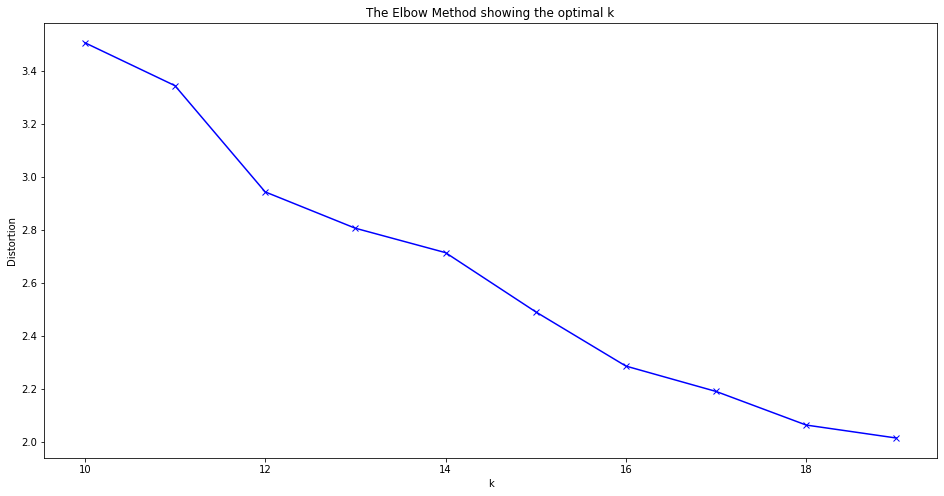

In [32]:
# Code from Predictive Hacks
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

You can see the **optimum k is 12**

In [33]:
# set number of clusters
kclusters = 12

capital_grouped_clustering = capital_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(capital_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 0, 0, 4, 6, 0, 3, 0, 4], dtype=int32)

Now let's add the clusters labels to the capitals dataframe.

In [34]:
# add clustering labels
capital_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

capital_merged = capital_data

# merge capital_grouped with capital_data to add latitude/longitude for each city
capital_merged = capital_merged.join(capital_venues_sorted.set_index('City'), on='City')

capital_merged.head()

,Country,City,Population,% of total,Ranking,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,China,Beijing,21542000,1.50,0,39.91,116.39,4.0,Historic Site,Hotel,Chinese Restaurant,Park,History Museum,Metro Station,Peking Duck Restaurant,Sandwich Place,Scenic Lookout,Performing Arts Venue
1,Japan,Tokyo,13929286,11.03,1,35.68,139.76,0.0,Café,Chinese Restaurant,Chocolate Shop,Hotel,Japanese Restaurant,Sushi Restaurant,Steakhouse,Italian Restaurant,French Restaurant,Tea Room
2,DR Congo,Kinshasa,12691000,14.90,2,-4.32,15.31,8.0,Mobile Phone Shop,Bakery,Resort,Print Shop,Hotel,Fish & Chips Shop,Escape Room,Ethiopian Restaurant,Event Service,Event Space
3,Russia,Moscow,12506468,8.52,3,55.75,37.62,0.0,Plaza,Boutique,Coffee Shop,Hotel,History Museum,Italian Restaurant,Jewelry Store,Fountain,Art Gallery,Seafood Restaurant
4,Indonesia,Jakarta,10075310,3.76,4,-6.18,106.83,0.0,Indonesian Restaurant,Hotel,Coffee Shop,Café,Park,Japanese Restaurant,Convenience Store,Fast Food Restaurant,Breakfast Spot,Seafood Restaurant


In [35]:
# drop whole row with NaN in "Cluster Labels" column
capital_merged.dropna(subset=['Cluster Labels'], axis=0, inplace=True)

In [36]:
capital_merged['Cluster Labels'] = capital_merged['Cluster Labels'].astype('int')

In [37]:
capital_merged['Cluster Labels'].value_counts()

0     58
4     13
10     3
8      2
11     1
9      1
7      1
6      1
5      1
3      1
2      1
1      1
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters

In [38]:
# create map
map_clusters = folium.Map(location=[60, -80], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(capital_merged['Latitude'], capital_merged['Longitude'], capital_merged['City'], capital_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### We now have the clusters ready to analyze them.

Let's analyze the statistic information of each cluster.

In [39]:
clusters_data = []
labels = ['Population', '% of total', 'Ranking']
for i in range(0,12):
    cluster = capital_merged[capital_merged['Cluster Labels'] == i]
    numrows = len(cluster)
    mean_pop = cluster['Population'].mean()
    std_pop = cluster['Population'].std()
    max_pop = cluster['Population'].max()
    min_pop = cluster['Population'].min()
    mean_pct = cluster['% of total'].mean()
    std_pct = cluster['% of total'].std()
    max_pct = cluster['% of total'].max()
    min_pct = cluster['% of total'].min()
    mean_rank = cluster['Ranking'].mean()
    std_rank = cluster['Ranking'].std()
    max_rank = cluster['Ranking'].max()
    min_rank = cluster['Ranking'].min()
    clusters_data.append([i, numrows, mean_pop, std_pop, max_pop, min_pop, mean_pct, std_pct, max_pct, min_pct, mean_rank, std_rank, max_rank, min_rank])

In [40]:
df_clusters = pd.DataFrame(clusters_data)
df_clusters.columns = ['Cluster', 'Rows', 'Mean Population', 'Std Population', 'Max Population', 'Min Population', 'Mean % of total', 'Std % of total', 'Max % of total', 'Min % of total', 'Mean Ranking', 'Std Ranking', 'Max Ranking', 'Min Ranking']
df_clusters.sort_values('Rows', ascending=False)

,Cluster,Rows,Mean Population,Std Population,Max Population,Min Population,Mean % of total,Std % of total,Max % of total,Min % of total,Mean Ranking,Std Ranking,Max Ranking,Min Ranking
0,0,58,3.748088e+06,3.367727e+06,13929286,1003285,18.191724,21.163040,100.00,1.64,41.241379,24.616576,85,1
4,4,13,4.564516e+06,5.662696e+06,21542000,1399981,8.139231,4.721526,18.93,1.50,37.076923,20.758378,62,0
10,10,3,1.886158e+06,1.110305e+06,3140853,1030594,9.360000,1.796357,10.51,7.29,55.000000,27.221315,80,26
8,8,2,6.880600e+06,8.217146e+06,12691000,1070200,16.235000,1.887975,17.57,14.90,40.000000,53.740115,78,2
1,1,1,1.097133e+06,NaN,1097133,1097133,10.450000,NaN,10.45,10.45,75.000000,NaN,75,75
2,2,1,1.827000e+06,NaN,1827000,1827000,39.190000,NaN,39.19,39.19,47.000000,NaN,47,47
3,3,1,1.289626e+06,NaN,1289626,1289626,8.430000,NaN,8.43,8.43,66.000000,NaN,66,66
5,5,1,1.010970e+06,NaN,1010970,1010970,23.540000,NaN,23.54,23.54,83.000000,NaN,83,83
6,6,1,6.719500e+06,NaN,6719500,6719500,17.480000,NaN,17.48,17.48,17.000000,NaN,17,17
7,7,1,1.005231e+06,NaN,1005231,1005231,5.940000,NaN,5.94,5.94,84.000000,NaN,84,84


We can get a few insight from this data:
* Cluster 0 has the biggest capitals relative to their country total population, because mean % of total is high relative to others clusters.
* Cluster 4 has the bigger cities (Population) and have the smalest capitals relative to their country total population, because mean % of total is low relative to others clusters.

Let's further analyze these clusters using visualizations tools and their **Rankings**.

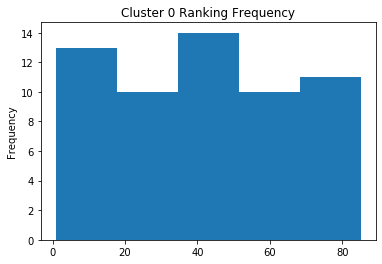

In [51]:
cluster_0 = capital_merged[capital_merged['Cluster Labels']==0]
cluster_0['Ranking'].plot(kind='hist', bins=5, title='Cluster 0 Ranking Frequency')

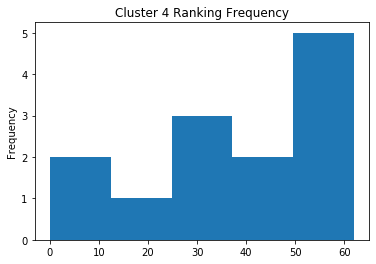

In [54]:
cluster_4 = capital_merged[capital_merged['Cluster Labels']==4]
cluster_4['Ranking'].plot(kind='hist', bins=5, title='Cluster 4 Ranking Frequency')

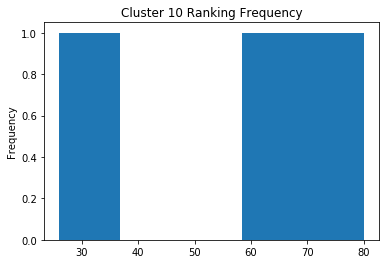

In [52]:
cluster_10 = capital_merged[capital_merged['Cluster Labels']==10]
cluster_10['Ranking'].plot(kind='hist', bins=5, title='Cluster 10 Ranking Frequency')

As you can see when plotting the histogram for Ranking:
* Cluster 0 has mostly an even distribution of cities on Ranking.
* Cluster 4 has mostly smaller cities.
* Cluster 10 has big and small cities.

### Let's check most frequent venues

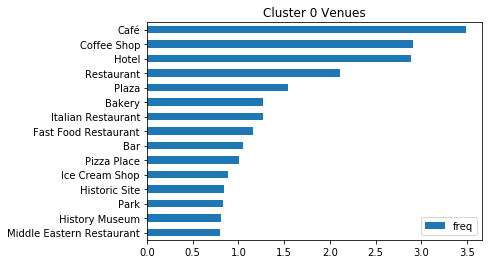

In [45]:
clus_group_0 = capital_grouped.join(cluster_0[['City']].set_index('City'), how='right', on='City')
df0 = pd.DataFrame(clus_group_0.sum())
# remove first row
df0 = df0.iloc[1: , :]
df0.columns = ['freq']
df0 = df0.sort_values(by='freq', ascending=True)
df0[-15:].plot(kind='barh', title='Cluster 0 Venues')

You could say that people from Cluster 0 cities like to **drink coffee**, eat at **cuisine restaurants** and **visit museums**.

##### Let's plot Cluster 0

In [46]:
# create map
map_clusters = folium.Map(location=[60, -80], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_0['Latitude'], cluster_0['Longitude'], cluster_0['City'], cluster_0['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

As you see, these are mostly **developed countries**.

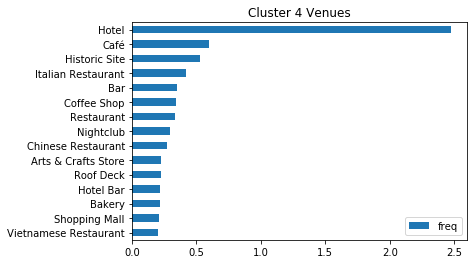

In [47]:
clus_group_4 = capital_grouped.join(cluster_4[['City']].set_index('City'), how='right', on='City')
df4 = pd.DataFrame(clus_group_4.sum())
df4 = df4.iloc[1: , :]
df4.columns = ['freq']
df4 = df4.sort_values(by='freq', ascending=True)
df4[-15:].plot(kind='barh', title='Cluster 4 Venues')

For Cluster 4, you could say that these cities are for **tourists who likes bars**.

##### Let's plot Cluster 4

In [48]:
# create map
map_clusters = folium.Map(location=[60, -80], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_4['Latitude'], cluster_4['Longitude'], cluster_4['City'], cluster_4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

As you can see, these are mostly Asian and Africa countries.

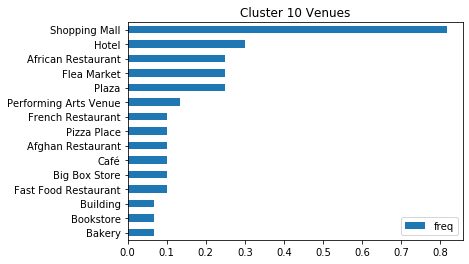

In [49]:
clus_group_10 = capital_grouped.join(cluster_10[['City']].set_index('City'), how='right', on='City')
df10 = pd.DataFrame(clus_group_10.sum())
df10 = df10.iloc[1: , :]
df10.columns = ['freq']
df10 = df10.sort_values(by='freq', ascending=True)
df10[-15:].plot(kind='barh', title='Cluster 10 Venues')

You could say that people from Cluster 10 cities like **shopping**.

##### Let's plot Cluster 10

In [50]:
# create map
map_clusters = folium.Map(location=[60, -80], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_10['Latitude'], cluster_10['Longitude'], cluster_10['City'], cluster_10['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

As you can see, these are **underdeveloped countries** with **low population**.

## Results and Discussion  <a name="results"></a>

#### Results

We made our analysis on the similarities of the world capitals, using the FourSqaure API. 

We made clusters using k-means algorithm and got 12 clusters as a result; 3 clusters with more than two countries and 9 smaller clusters with one or two countries.

Cluster 0 is the biggest cluster and has all the big cities from developed countries. It has coffee shops, diverse cuisine and cultural venues, which is very likely for a big city.

Cluster 4 is much smaller than Cluster 0 and has mostly Hotels and some restaurants or bars. Most of the countries in Cluster 4 are in Asia or Africa.

Cluster 10 has only three countries, where you can find different shopping venues and African restaurants.

#### Discussion

This project could have brought us more insights if we had enriched our data with demographic stats or GDP information.

For further insights, it could be useful to run Cluster 0 through a k-means clustering, because it has many countries in it and maybe they aren't that close to each other, but disimilar to other clusters.

## Conclusion  <a name="conclusion"></a>

The idea behind this project was to find out if there are any similarities between capitals. 

We can tell by the results that developed countries capitals share common venues, all of them having lots of food and cultural venues, which is logical for countries where there is a lot of white collar jobs and cultural investment.

Also, African capitals have similarities with South Asian capitals. This is, having lots of hotels and bars, but not so many museums or cultural investment.

In conclusion, developed countries have a more diversified service universe, such as entertainment, hotels, cuisine, art and cultural venues, etc. While underdevelopment countries focus more on food and hotels.